## EKC.01.047.04.normalization_and_ODE_fitting

### Rationale
Goal is to get robust measurements of $k_{add}$ for ATP, GTP, CTP, UTP. Suffer from a major challenge of multiple DMS products. Decided that at this point, I will measure decay in unmodified NTP for this manuscript. This clearly warrants a deeper quantitation of each product, but a rough kadd will suffice as long as it is robust.

### Experimental method

- 5 mM (nominal) NTP was probed at various temperatures in pH-adjusted buffer that match probing buffer (150 mM bis-tris (pK<sub>a</sub> 6.35), 15 mM KHPO<sub>4</sub>, 25 mM KCl, pH 6.5
- Reaction started, transferred to a pre-warmed NMR tube, then time-resolved 1D NMR
- All reaction time offsets were measured and adjusted as x-axis offset in the data
- I also more carefully measured concentration of NTPs, so I can use this for ODE's later.

### Mnova analysis

- Used "Reaction monitoring wizard" to import all fids within folders
- Applied auto phase correction and baseline correction
    - When necessary, I do baseline correction within the local ppm around the peaks
- Peak assignment TODO
    - need to fill in details on what's what for each NTP
- Output here are raw peak integrals for various peaks that were visible

### Peak pre-normalization

- Pre-normalization is taking the dividing each raw peak integral by the sum of all peaks in the 8ppm and 6ppm regions (these correspond to adjacent carbons within the base and sugar).
- Rationale here is that there are baseline correction artifacts during mnova analysis that causes random spikes sometimes.
- Sum of peaks within a region (like around 8ppm) must be linear (or no change), but often this is not the case. This pre-normalization often works well to reveal improved decay curves.
- However, these are NOT true percentages at this point. Peak integral-to-proton ratio is not the same for each of the products, cannot assume that these are percentages although they look like percentages. This is why I'm calling this pre-normalization. 
- My primary purpose and goal is: 1) get clean exponential decay curves, 2) use these to esimate max peak integral (this is what's equivalent to 100% of product). 
- I will then use this to normalize raw peak integrals to product %. 
    - I do this for both NTPs and DMS.
    - There are varying levels of fit quality for NTP peaks, ideally they would all agree with each other. 
    - I'll use my best judgement and perhaps some fit criteria to decide on which ones I'll use in my fits.
    - Hypothesis is that these rates should obey Arrhenius. 
    - Pre-normalization is actually done below.

### Data fitting

- Technically I can fit the data to the integrated model. However, at 5 mM NTP (15.64 mM DMS), I feel like I'd be breaking the key assumption. Best to do ODE.
- This is what the code below will do

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from lmfit import Model
from lmfit.models import ExponentialModel
import glob
from pathlib import Path
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from lmfit import minimize, Parameters
from lmfit.model import load_modelresult

import matplotlib as mpl

# Set Helvetica font globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Helvetica']

# Optional: make sure fonts are updated
mpl.rcParams['pdf.fonttype'] = 42  # Avoids Type 3 fonts in PDF output
mpl.rcParams['ps.fonttype'] = 42

In [2]:
eyring_khydr = load_modelresult('k_hydr.sav')

def calc_khydr(temp):
    x = 1 / (temp + 273.15)
    y = eyring_khydr.eval(x=x) # lnk/T
    kT = np.exp(y)
    k = kT * (temp + 273.15)
    return k

In [3]:
sorted(glob.glob('./*/*.csv'))

['./ATP_normalized_peaks/20_1_peak6.csv',
 './ATP_normalized_peaks/20_1_peak8.csv',
 './ATP_normalized_peaks/20_1_peak8_raw.csv',
 './ATP_normalized_peaks/20_1_peakDMS.csv',
 './ATP_normalized_peaks/37_1_peak6.csv',
 './ATP_normalized_peaks/37_1_peak6_raw.csv',
 './ATP_normalized_peaks/37_1_peak8.csv',
 './ATP_normalized_peaks/37_1_peakDMS.csv',
 './ATP_normalized_peaks/37_2_peak6.csv',
 './ATP_normalized_peaks/37_2_peak8.csv',
 './ATP_normalized_peaks/37_2_peakDMS.csv',
 './ATP_normalized_peaks/42_1_peak6.csv',
 './ATP_normalized_peaks/42_1_peak8.csv',
 './ATP_normalized_peaks/42_1_peakDMS.csv',
 './ATP_normalized_peaks/42_2_peak6.csv',
 './ATP_normalized_peaks/42_2_peak8.csv',
 './ATP_normalized_peaks/42_2_peakDMS.csv',
 './ATP_normalized_peaks/48_1_peak6.csv',
 './ATP_normalized_peaks/48_1_peak6_raw.csv',
 './ATP_normalized_peaks/48_1_peak8.csv',
 './ATP_normalized_peaks/48_1_peakDMS.csv',
 './ATP_normalized_peaks/48_2_peak6.csv',
 './ATP_normalized_peaks/48_2_peak6_raw.csv',
 './AT

In [4]:
def exp_decay_3factor(x, diff, k, plat):
    return diff * np.exp(-k * x) + plat

def fit_exp_decay(peak_df):

    # Create model
    exp_decay = Model(exp_decay_3factor)

    # Create and guess initial parameters
    diff_est = peak_df['peak'].max() - peak_df['peak'].min()
    plat_est = peak_df['peak'].min()
    params = exp_decay.make_params(diff = diff_est, k = 0.0001, plat = plat_est)

    # Fit model
    result = exp_decay.fit(peak_df['peak'], params, x=peak_df['time'])
    return result

def calc_max(exp_decay_fit):
    # Calculate max and max error
    max = exp_decay_fit.params['plat'].value + exp_decay_fit.params['diff'].value
    max_err = ((exp_decay_fit.params['plat'].stderr ** 2) + (exp_decay_fit.params['diff'].stderr ** 2)) ** 0.5
    return max, max_err

In [5]:
### INTEGRAL Pre-normalization

ntps = ['ATP', 'CTP', 'GTP', 'UTP']
temps = {'ATP': [20, 37, 42, 48],
         'CTP': [25, 37, 42, 48],
         'GTP': [25, 33, 42, 48],
         'UTP': [20]}

for ntp in ntps:
    for temp in temps[ntp]:
        all_peaks = []
        all_params = []
        all_reps = []
        for csv in sorted(glob.glob(f'./{ntp}*/{temp}*.csv')):
            raw_peak_df = pd.read_csv(csv)
            raw_peak_decay = fit_exp_decay(raw_peak_df)
            max, max_err = calc_max(raw_peak_decay)

            perc_peak_df = raw_peak_df.copy()
            perc_peak_df['peak'] = perc_peak_df['peak'] / max

            # Create directory if it doesn't exist use Path
            Path(f'./{ntp}_peak_percentages/').mkdir(parents=True, exist_ok=True)
            
            # Save percentage peak data
            perc_peak_df.to_csv(f'./{ntp}_peak_percentages/{csv.split("/")[-1]}', index=False)

In [117]:

            peak_decay = fit_exp_decay(perc_peak_df)

            # save all params and errors in a list
            peak = '_'.join(csv.split('/')[-1].split('_')[2:])
            rep = csv.split('/')[-1].split('_')[1]
            params = []
            for param in peak_decay.params:
                params.append(peak_decay.params[param].value)
                params.append(peak_decay.params[param].stderr)
            params.append(peak_decay.rsquared)
            all_params.append(params)
            all_peaks.append(peak)
            all_reps.append(rep)

        summary_df = pd.DataFrame(all_params, columns=['diff', 'diff_err', 'k', 'k_err', 'plat', 'plat_err', 'rsquared'])
        summary_df['peak'] = all_peaks
        summary_df['rep'] = all_reps
        summary_df


IndentationError: unexpected indent (420269089.py, line 15)

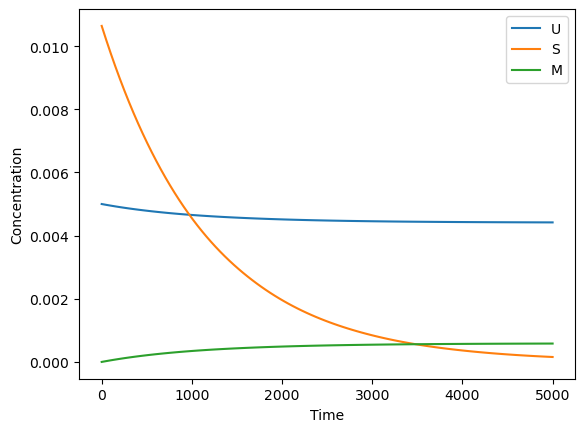

In [6]:
# Define the system of ODEs
def system(t, y, k1, k2):
    U, S, M = y
    dUdt = -k1 * U * S
    dSdt = - k1 * U * S - k2 * S
    dMdt = k1 * U * S
    return [dUdt, dSdt, dMdt]

# Initial conditions
U0 = 0.005
S0 = 0.01064
M0 = 0.0
y0 = [U0, S0, M0]

# Rate constants
k1 = 0.01 # kadd /s
k2 = 0.0008 # khydr /s

# Time span
t_span = [0, 5000]

# Solve the ODE
sol = solve_ivp(system, t_span, y0, args=(k1, k2), dense_output=True)

# Print the solution
t = np.linspace(t_span[0], t_span[1], 100)
y = sol.sol(t)

# Plot the solution
plt.plot(t, y.T)
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.legend(['U', 'S', 'M'])
plt.show()

In [40]:
def fit_ODE(dms_perc, peak_perc, temp, ntp_conc, plot_out):

    # for whichever has a shorter length between dms_perc and peak_perc, use those time values
    if len(dms_perc) < len(peak_perc):
        t_obs = list(dms_perc['time'].values)
    else:
        t_obs = list(peak_perc['time'].values)

    # filter both to observed time values
    peak_perc = peak_perc[peak_perc['time'].isin(t_obs)]
    dms_perc = dms_perc[dms_perc['time'].isin(t_obs)]

    RNACONC = ntp_conc
    DMSCONC = 0.01564

    # Replace these lists with your actual data
    U_data = list(peak_perc['peak'].values * RNACONC)
    S_data = list(dms_perc['peak'].values * DMSCONC)
    M_data = list((1 - peak_perc['peak']).values * RNACONC)

    # Create y_obs as a 2D array with one row for each of U, S, and M
    y_obs = np.array([U_data, S_data, M_data])

    # Define the system of ODEs
    def system(t, y, k1, k2):
        U, S, M = y
        dUdt = -k1 * U * S
        dSdt = - k1 * U * S - k2 * S
        dMdt = k1 * U * S
        return [dUdt, dSdt, dMdt]

    # Wrapper function for solve_ivp that takes time values and parameters as input
    def solve_system(params, t, data):
        k1 = params['k1']
        k2 = params['k2']
        S_factor = params['S_factor']
        # adjust S by S_factor
        data[1] = data[1] * S_factor

        # solve starting at t = 0 and ending at the last time point in t_obs
        fill_in = np.linspace(0, t[0], 51)[:-1]
        full_t = np.concatenate((fill_in, t))
        sol = solve_ivp(system, [0, t[-1]], y0, args=(k1, k2), t_eval=full_t, vectorized=True)

        # take only the values at the observed time points index 50 onwards
        sol_observed = sol.y[:, 50:]

        return (sol_observed.ravel() - data)

    # Initial conditions
    U0 = RNACONC
    S0 = DMSCONC
    M0 = 0.0
    y0 = [U0, S0, M0]

    # Time values
    t = t_obs

    # Observed data
    # Replace this with your actual data
    y_obs = np.array([U_data, S_data, M_data])

    # Define parameters

    k2_initial = calc_khydr(temp)
    params = Parameters()
    params.add('k1', value = 0.003)
    params.add('k2', value = k2_initial, vary=True)  # set vary=False to keep k2 constant
    params.add('S_factor', value = 1.0, vary=False)  # set vary=False to keep S constant

    # Fit the parameters
    out = minimize(solve_system, params, args=(t, y_obs.ravel()))

    # Print the fitted parameters
    print(out.params)

    # Print the fitted parameters and their standard deviations
    for name, param in out.params.items():
        print(f'{name} = {param.value} ± {param.stderr}')

    # Calculate R-squared
    ss_res = np.sum(out.residual**2)
    ss_tot = np.sum((y_obs - np.mean(y_obs))**2)
    r_squared = 1 - (ss_res / ss_tot)

    print('R-squared:', r_squared)

    # Calculate chi-sq
    chi_sq = np.sum(out.residual**2) / (len(t) - len(out.params))
    print('Chi-squared:', chi_sq)

    # plot 
    fill_in = np.linspace(0, t[0], 51)[:-1]
    full_t = np.concatenate((fill_in, t))
    sol = solve_ivp(system, [0, t[-1]], y0, args=(out.params['k1'].value, out.params['k2'].value), t_eval=full_t, vectorized=True)
    # take only the values at the observed time points index 50 onwards
    sol_fit = sol.y[:, 50:]

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    axs[0].plot(t, y_obs.T, marker='o', linestyle='none')
    axs[0].plot(t, sol_fit.T)
    axs[0].set_xlabel('Time')
    axs[0].set_ylabel('Concentration')
    axs[0].legend(['U', 'S', 'M', 'U_fit', 'S_fit', 'M_fit'])

    # Plot U on axs[1]
    axs[1].plot(t, y_obs[0], marker='o', linestyle='none')
    axs[1].plot(t, sol_fit[0])
    axs[1].set_xlabel('Time')
    axs[1].set_ylabel('Concentration')
    #axs[1].legend(['U', 'U_fit'])

    plt.tight_layout()
    plt.savefig(plot_out)

    return out.params, r_squared, chi_sq

In [55]:
def fit_ODE_new(dms_perc, peak_perc, temp, ntp_conc, plot_out):

    # for whichever has a shorter length between dms_perc and peak_perc, use those time values
    if len(dms_perc) < len(peak_perc):
        t_obs = list(dms_perc['time'].values)
    else:
        t_obs = list(peak_perc['time'].values)

    # filter both to observed time values
    peak_perc = peak_perc[peak_perc['time'].isin(t_obs)]
    dms_perc = dms_perc[dms_perc['time'].isin(t_obs)]

    RNACONC = ntp_conc
    DMSCONC = 0.01564

    # Replace these lists with your actual data
    U_data = list(peak_perc['peak'].values * RNACONC)
    S_data = list(dms_perc['peak'].values * DMSCONC)
    M_data = list((1 - peak_perc['peak']).values * RNACONC)

    # Create y_obs as a 2D array with one row for each of U, S, and M
    y_obs = np.array([U_data, S_data, M_data])

    # Define the system of ODEs
    def system(t, y, k1, k2):
        U, S, M = y
        dUdt = -k1 * U * S
        dSdt = - k1 * U * S - k2 * S
        dMdt = k1 * U * S
        return [dUdt, dSdt, dMdt]

    # Wrapper function for solve_ivp that takes time values and parameters as input
    def solve_system(params, t, data):
        k1 = params['k1']
        k2 = params['k2']
        S_factor = params['S_factor']
        # adjust S by S_factor
        data[1] = data[1] * S_factor

        # solve starting at t = 0 and ending at the last time point in t_obs
        fill_in = np.linspace(0, t[0], 51)[:-1]
        full_t = np.concatenate((fill_in, t))
        sol = solve_ivp(system, [0, t[-1]], y0, args=(k1, k2), t_eval=full_t, vectorized=True)

        # take only the values at the observed time points index 50 onwards
        sol_observed = sol.y[:, 50:]

        return (sol_observed.ravel() - data)

    # Initial conditions
    U0 = RNACONC
    S0 = DMSCONC
    M0 = 0.0
    y0 = [U0, S0, M0]

    # Time values
    t = t_obs

    # Observed data
    # Replace this with your actual data
    y_obs = np.array([U_data, S_data, M_data])

    # Define parameters

    k2_initial = calc_khydr(temp)
    params = Parameters()
    params.add('k1', value = 0.003)
    params.add('k2', value = k2_initial, vary=True)  # set vary=False to keep k2 constant
    params.add('S_factor', value = 1.0, vary=False)  # set vary=False to keep S constant

    # Fit the parameters
    out = minimize(solve_system, params, args=(t, y_obs.ravel()))

    # Print the fitted parameters
    print(out.params)

    # Print the fitted parameters and their standard deviations
    for name, param in out.params.items():
        print(f'{name} = {param.value} ± {param.stderr}')

    # Calculate R-squared
    ss_res = np.sum(out.residual**2)
    ss_tot = np.sum((y_obs - np.mean(y_obs))**2)
    r_squared = 1 - (ss_res / ss_tot)

    print('R-squared:', r_squared)

    # Calculate chi-sq
    chi_sq = np.sum(out.residual**2) / (len(t) - len(out.params))
    print('Chi-squared:', chi_sq)

    # plot 
    fill_in = np.linspace(0, t[0], 51)[:-1]
    full_t = np.concatenate((fill_in, t))
    sol = solve_ivp(system, [0, t[-1]], y0, args=(out.params['k1'].value, out.params['k2'].value), t_eval=full_t, vectorized=True)
    # take only the values at the observed time points index 50 onwards
    sol_fit = sol.y[:, 50:]

    fig, axs = plt.subplots(2, 1, figsize=(3, 3), sharex = True)

    # axs[0].plot(t, y_obs.T, marker='o', linestyle='none')
    # axs[0].plot(t, sol_fit.T)

    # #y_obs_frac = y_obs / np.sum(y_obs, axis=0)  # normalize across rows (U, S, M)
    # #axs[0].plot(t, y_obs_frac.T, marker='o', linestyle='none')

    # #sol_fit_frac = sol_fit / np.sum(sol_fit, axis=0)
    # #axs[0].plot(t, sol_fit_frac.T)

    # axs[0].set_xlabel('Time')
    # axs[0].set_ylabel('Concentration')
    # axs[0].legend(['U', 'S', 'M', 'U_fit', 'S_fit', 'M_fit'])

    # Plot U on axs[1]

    axs[0].scatter(t, y_obs[0] / U0, s = 15, color = '#69847d', label = '')
    axs[0].plot(t, sol_fit[0] / U0, color = '#69847d', label = 'C8')
    axs[0].legend(frameon = False)

    axs[1].scatter(t, y_obs[2] / U0, s = 15, color = '#95c8bf', label = '')
    axs[1].plot(t, sol_fit[2] / U0, color = '#95c8bf', label = 'C8-CH3')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Fraction species')
    axs[1].legend(frameon = False)
    #axs[1].legend(['U', 'U_fit'])

    # Hide spines between axes
    axs[0].spines['bottom'].set_visible(False)
    axs[1].spines['top'].set_visible(False)
    axs[0].tick_params(labeltop=False)  # don't put tick labels at top
    axs[1].xaxis.tick_bottom()

    plt.tight_layout()
    plt.savefig(plot_out)

    return out.params, r_squared, chi_sq

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


Parameters([('k1', <Parameter 'k1', value=np.float64(0.003919578110238277) +/- 3.59e-05, bounds=[-inf:inf]>), ('k2', <Parameter 'k2', value=np.float64(0.0008082771657965208) +/- 1.4e-06, bounds=[-inf:inf]>), ('S_factor', <Parameter 'S_factor', value=1.0 (fixed), bounds=[-inf:inf]>)])
k1 = 0.003919578110238277 ± 3.5934205215061495e-05
k2 = 0.0008082771657965208 ± 1.403116843037383e-06
S_factor = 1.0 ± 0
R-squared: 0.9998864148899463
Chi-squared: 4.259869773452474e-09


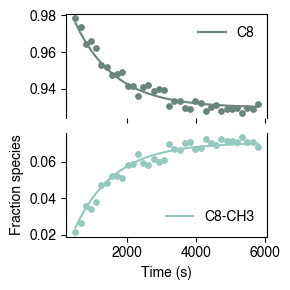

In [56]:
ntp_conc_dict = {'ATP': 0.0080045, 'CTP': 0.0073565, 'GTP': 0.006252, 'UTP': 0.007127}

ntp = 'ATP'
temp = 37
rep = 1
peak = '8'

dms_perc = pd.read_csv(f'./{ntp}_peak_percentages/{temp}_{rep}_peakDMS.csv')
peak_perc = pd.read_csv(f'./{ntp}_peak_percentages/{temp}_{rep}_peak{peak}.csv')
params, rsq, chisq = fit_ODE_new(dms_perc, peak_perc, temp, ntp_conc_dict[ntp], f'./{ntp}_{temp}_{rep}_{peak}_fit.pdf')

Parameters([('k1', <Parameter 'k1', value=0.0008680792500306464 +/- 4.56e-05, bounds=[-inf:inf]>), ('k2', <Parameter 'k2', value=0.00018361117068531134 +/- 2.18e-06, bounds=[-inf:inf]>), ('S_factor', <Parameter 'S_factor', value=1.0 (fixed), bounds=[-inf:inf]>)])
k1 = 0.0008680792500306464 ± 4.564957071417143e-05
k2 = 0.00018361117068531134 ± 2.184351178600168e-06
S_factor = 1.0 ± 0
R-squared: 0.9938094870524231
Chi-squared: 2.2726284214511577e-07
ATP 20 1 peak8
Parameters([('k1', <Parameter 'k1', value=0.003054759516309561 +/- 6.01e-05, bounds=[-inf:inf]>), ('k2', <Parameter 'k2', value=0.0001690322774878902 +/- 2e-06, bounds=[-inf:inf]>), ('S_factor', <Parameter 'S_factor', value=1.0 (fixed), bounds=[-inf:inf]>)])
k1 = 0.003054759516309561 ± 6.012755486713181e-05
k2 = 0.0001690322774878902 ± 1.997530091938955e-06
S_factor = 1.0 ± 0
R-squared: 0.9905698292506191
Chi-squared: 2.1877857960616273e-07
ATP 20 1 peak8_raw
Parameters([('k1', <Parameter 'k1', value=0.0001495361365156609 +/- 3

/var/folders/rk/c0mhzq9s7ms9j6q498s7gsw40000gn/T/ipykernel_11182/2996099648.py:99: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(10, 4))


CTP 37 2 peak8
Parameters([('k1', <Parameter 'k1', value=0.003087523601390532 +/- 5.12e-05, bounds=[-inf:inf]>), ('k2', <Parameter 'k2', value=0.000792363022253364 +/- 1.84e-06, bounds=[-inf:inf]>), ('S_factor', <Parameter 'S_factor', value=1.0 (fixed), bounds=[-inf:inf]>)])
k1 = 0.003087523601390532 ± 5.116664644234488e-05
k2 = 0.000792363022253364 ± 1.8385570923240643e-06
S_factor = 1.0 ± 0
R-squared: 0.9997669434563478
Chi-squared: 7.888353249536364e-09
CTP 37 1 peak6
Parameters([('k1', <Parameter 'k1', value=0.003293579540169428 +/- 4.91e-05, bounds=[-inf:inf]>), ('k2', <Parameter 'k2', value=0.0007909541234363747 +/- 1.75e-06, bounds=[-inf:inf]>), ('S_factor', <Parameter 'S_factor', value=1.0 (fixed), bounds=[-inf:inf]>)])
k1 = 0.003293579540169428 ± 4.910527300145528e-05
k2 = 0.0007909541234363747 ± 1.7544198686081254e-06
S_factor = 1.0 ± 0
R-squared: 0.9997850460612022
Chi-squared: 7.202153076171089e-09
CTP 37 1 peak8
Parameters([('k1', <Parameter 'k1', value=0.00279214213090097

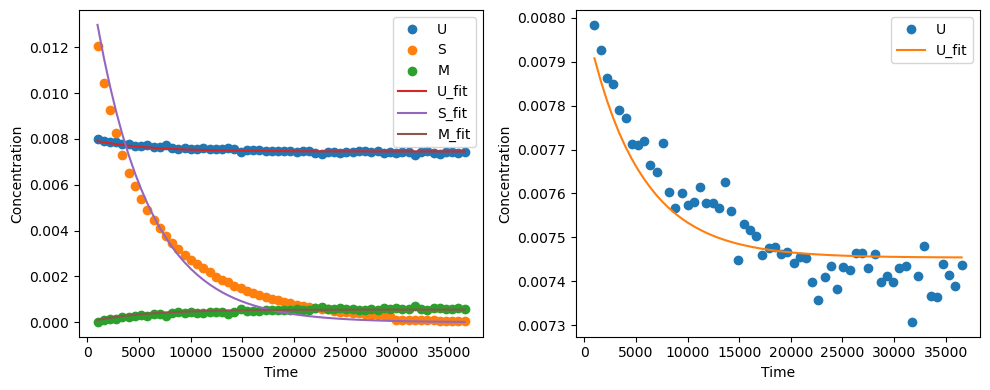

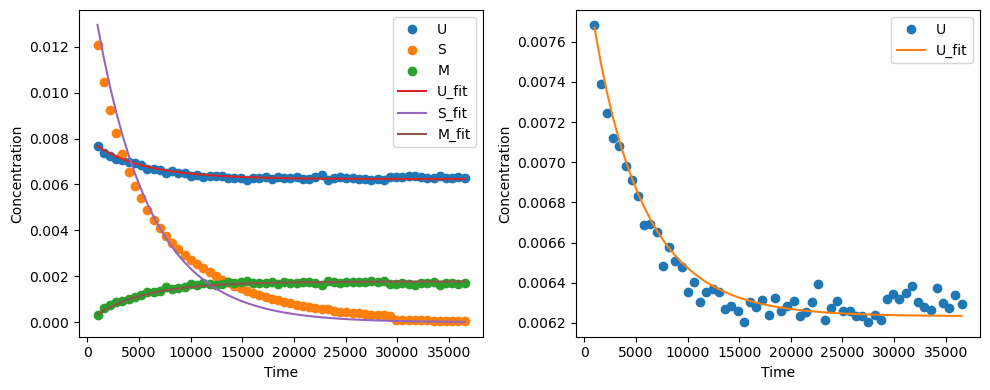

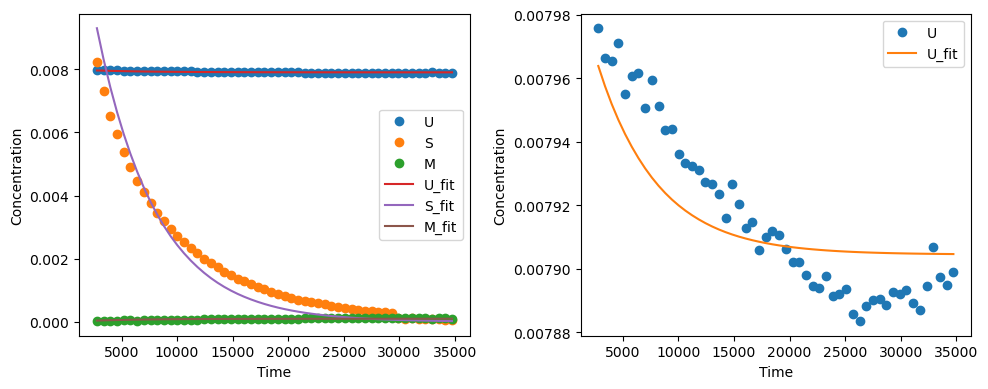

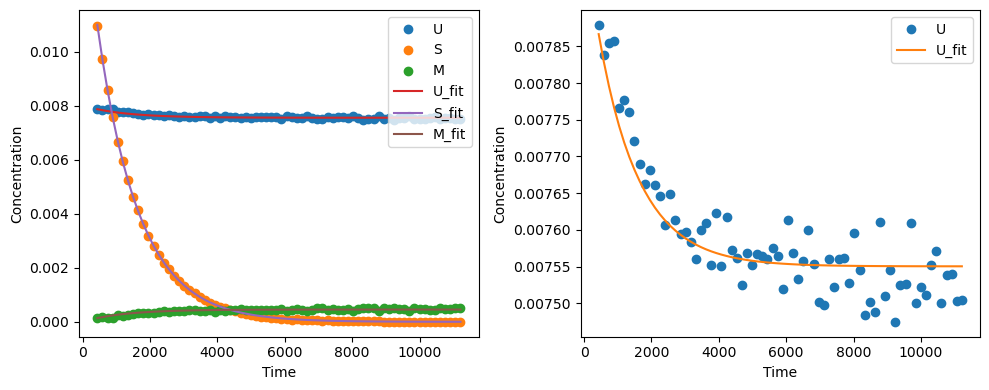

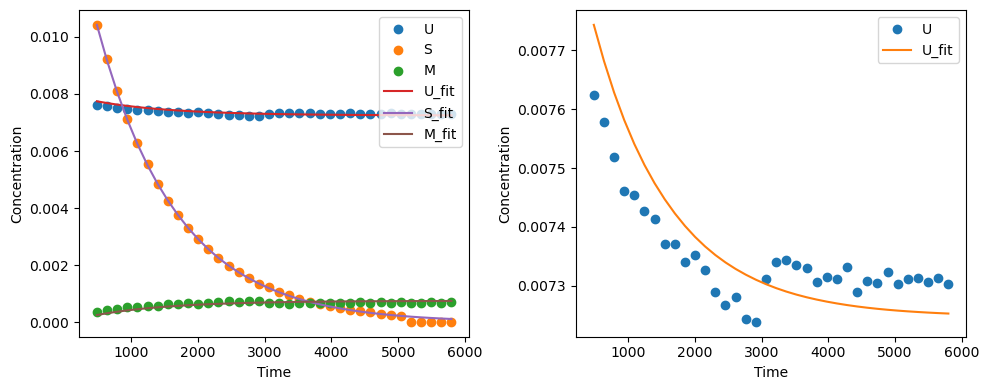

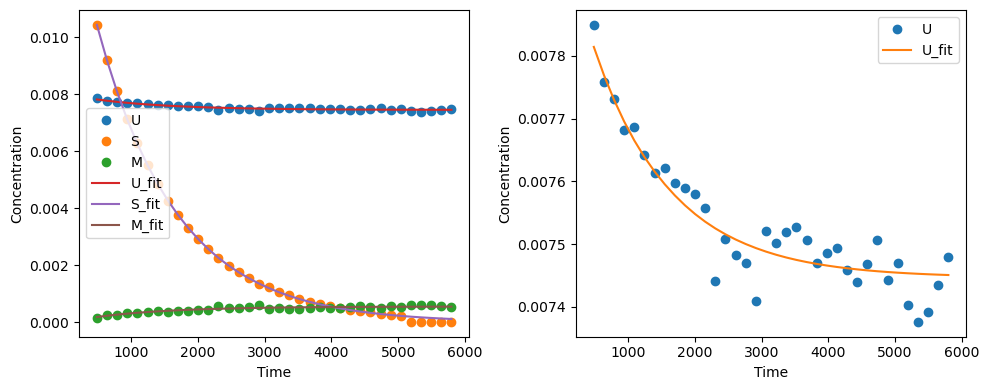

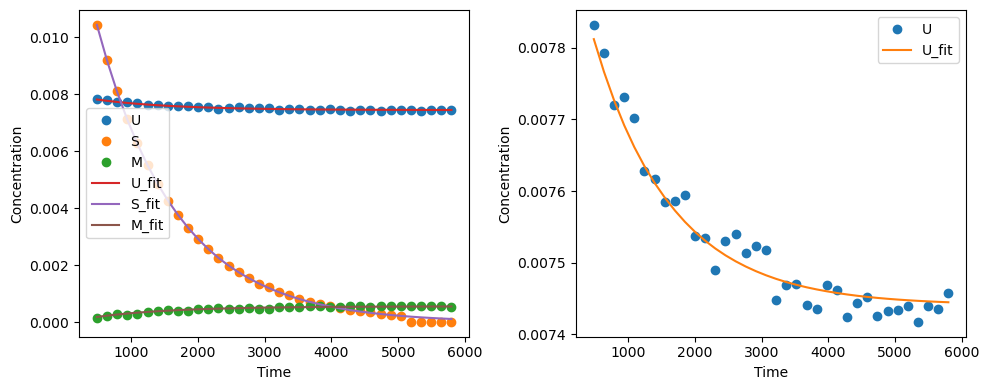

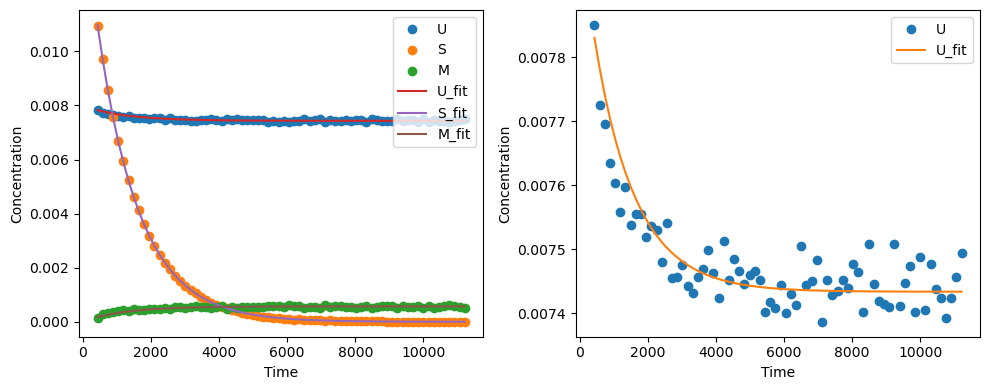

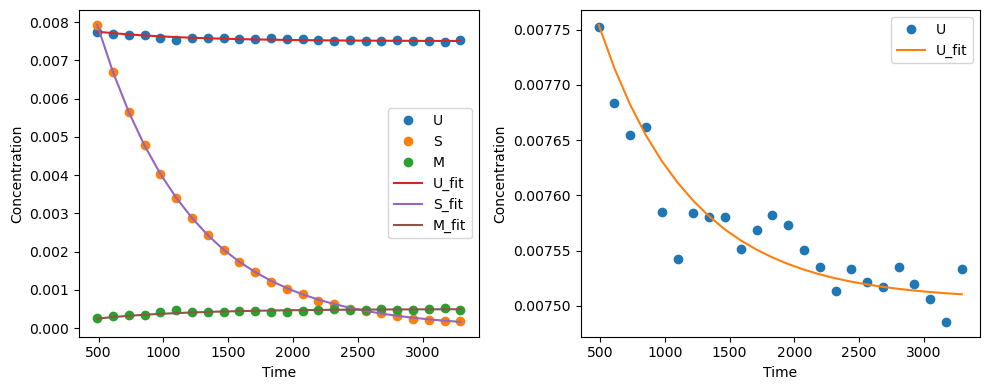

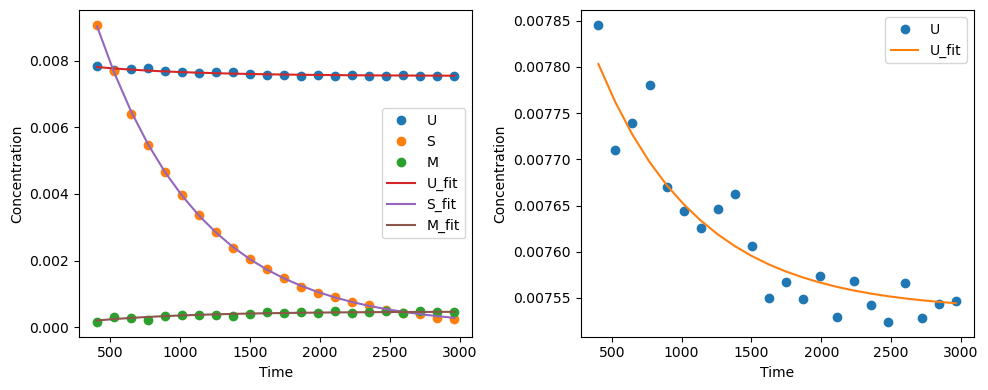

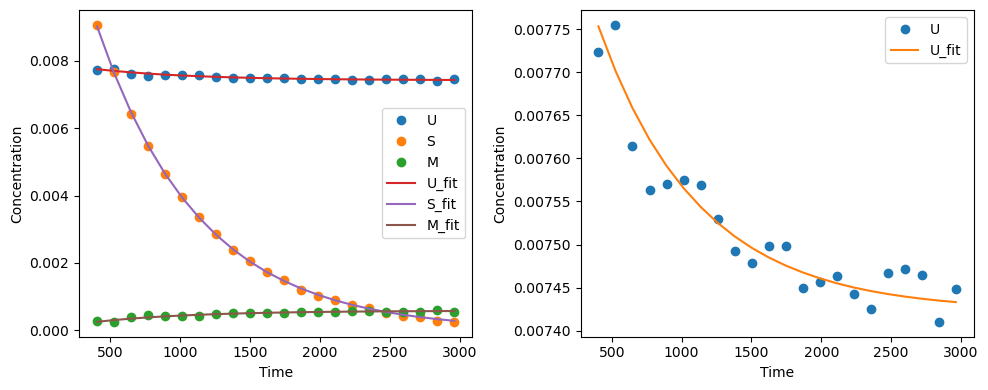

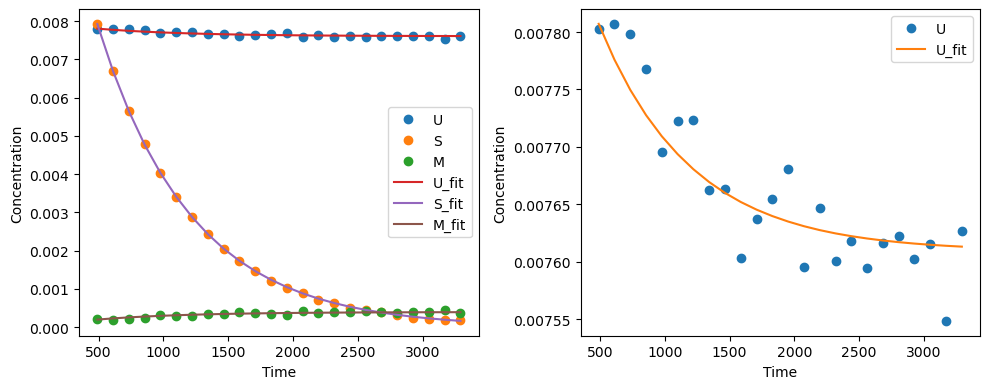

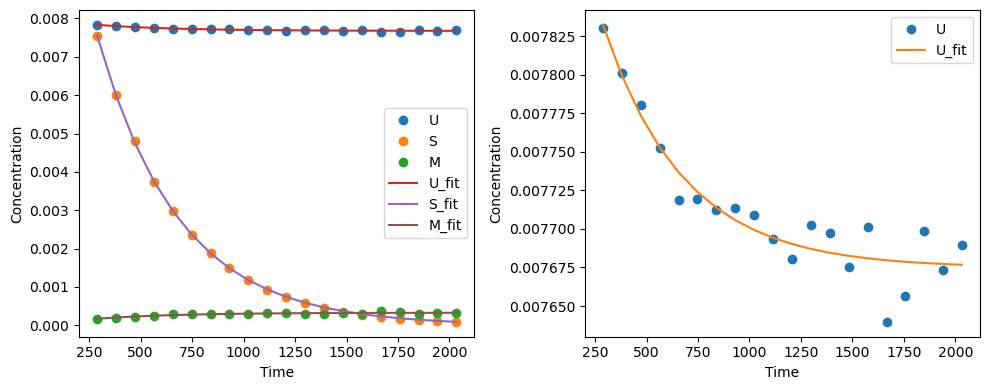

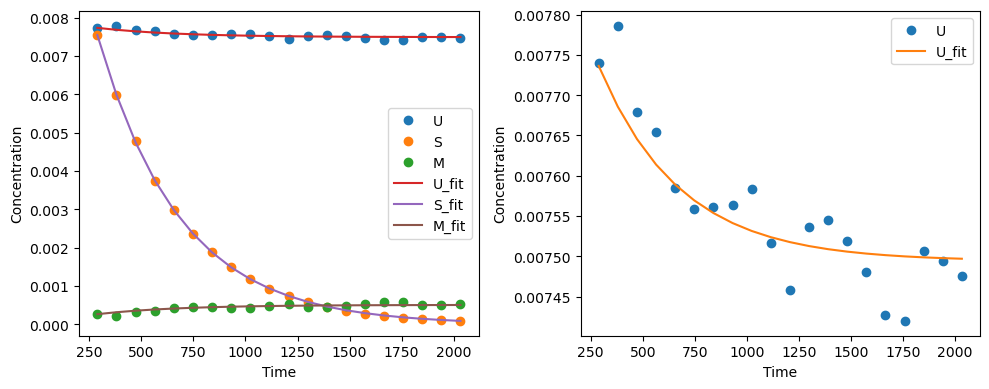

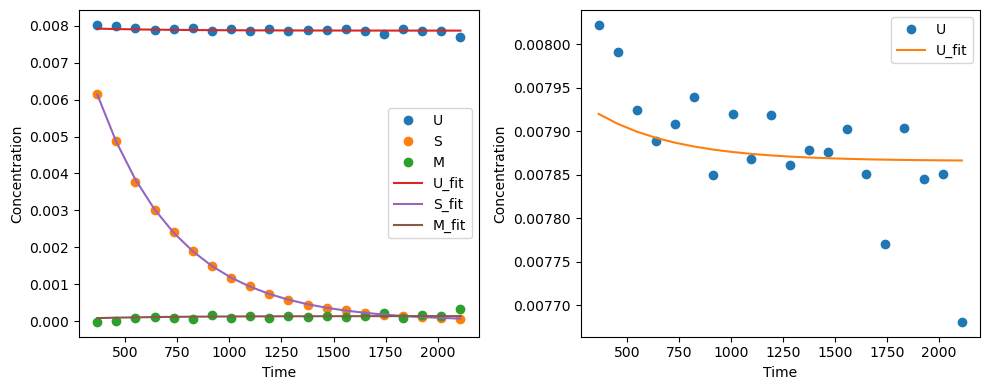

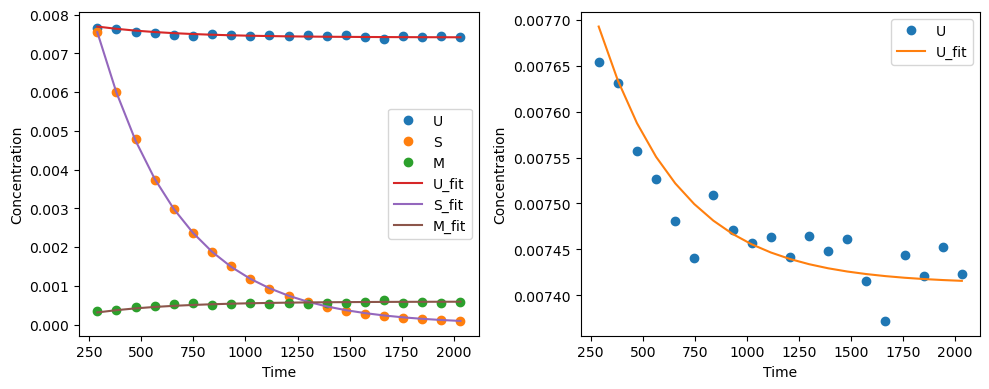

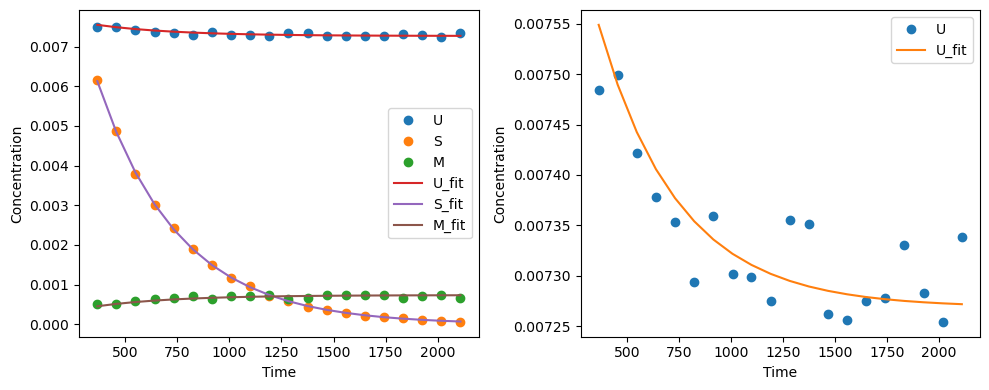

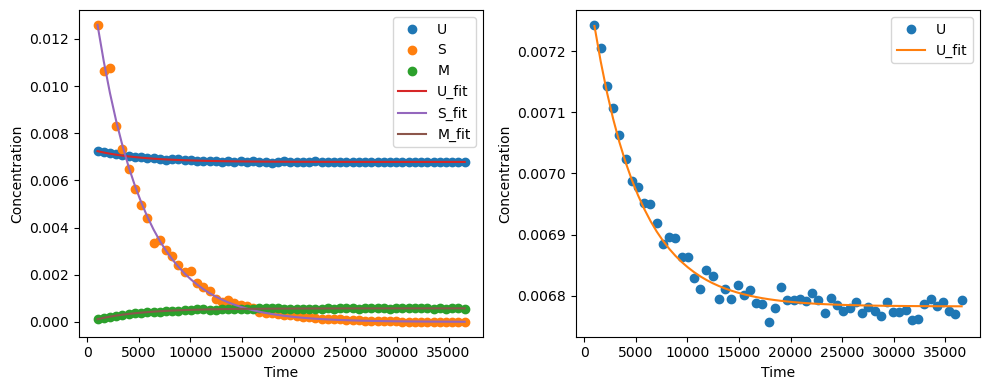

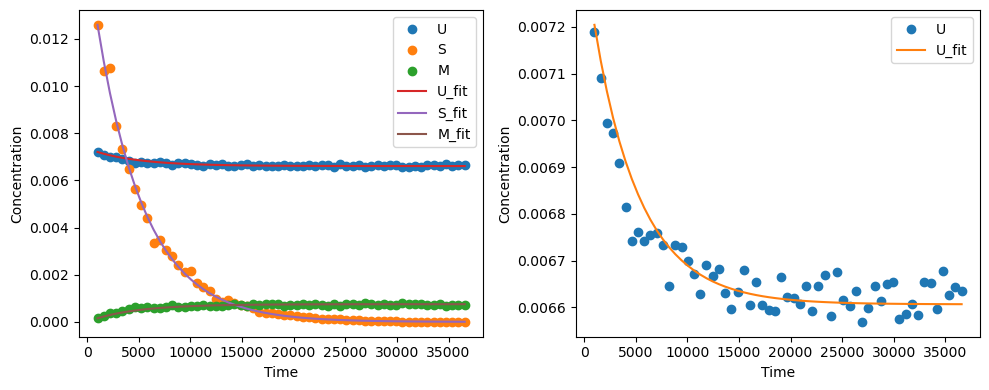

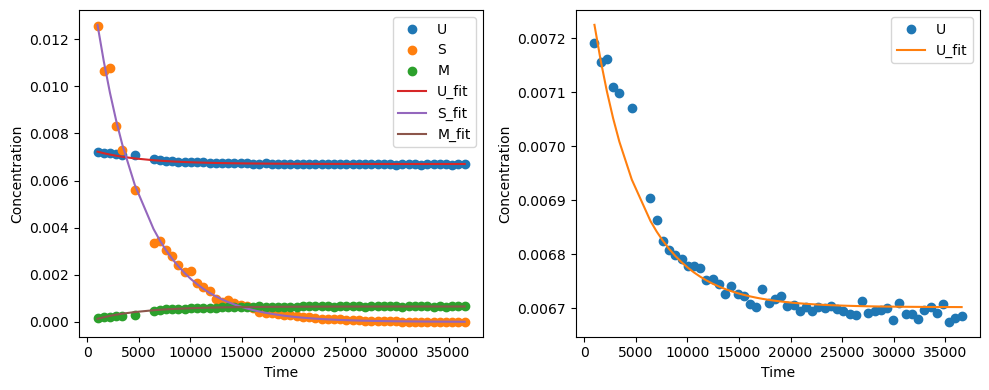

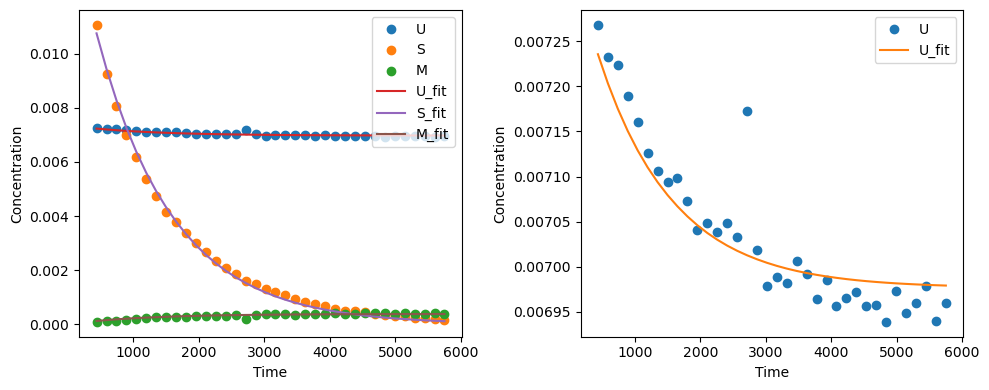

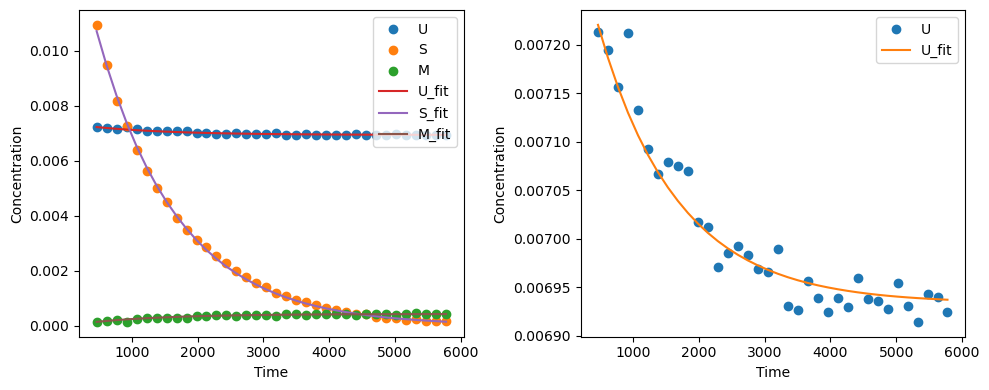

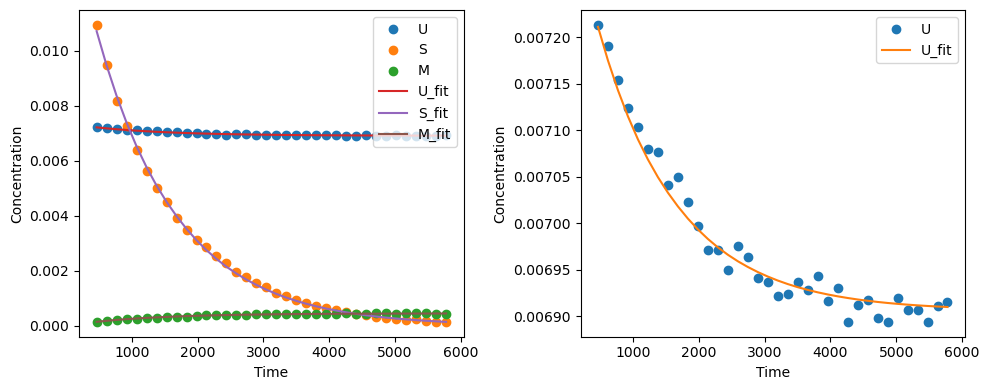

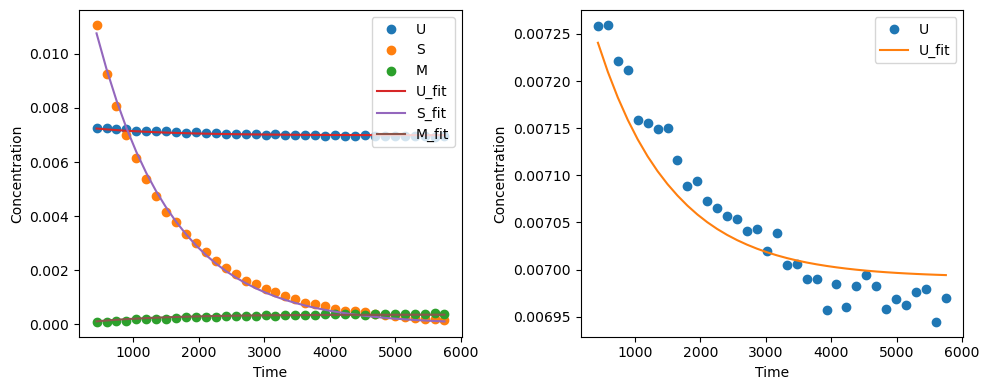

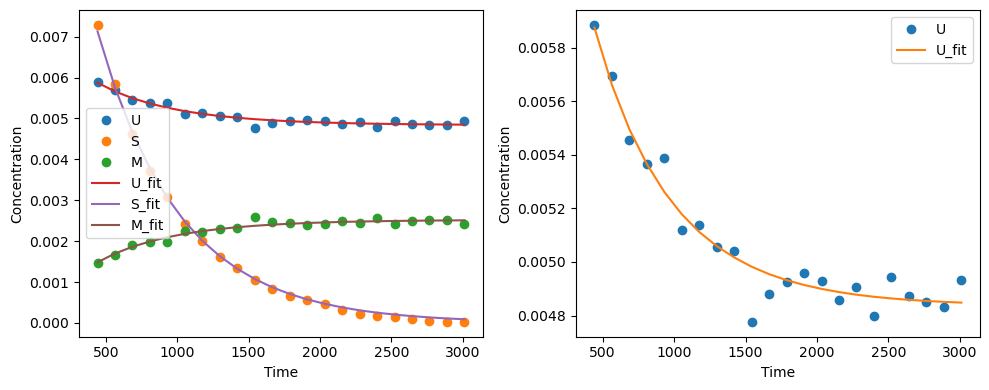

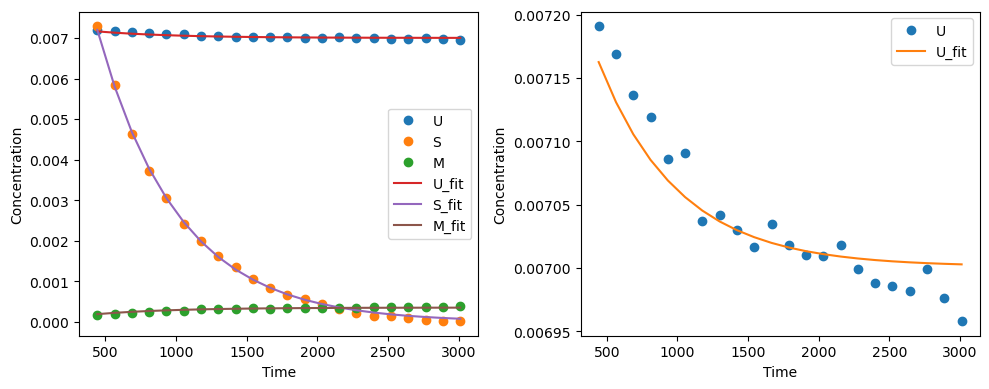

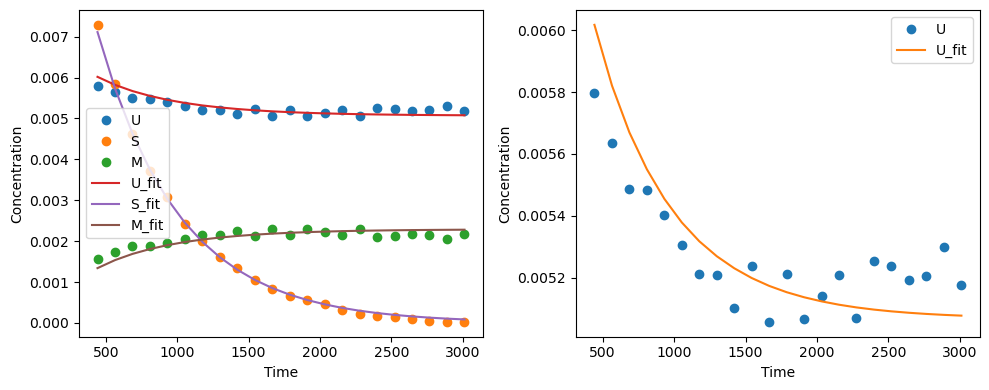

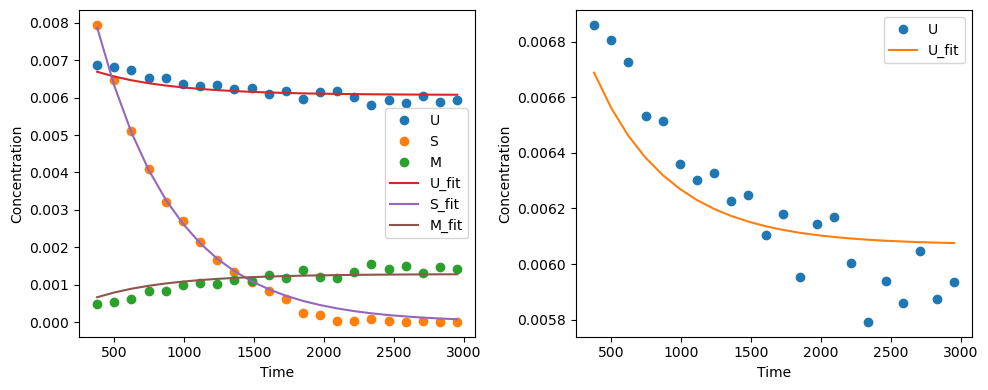

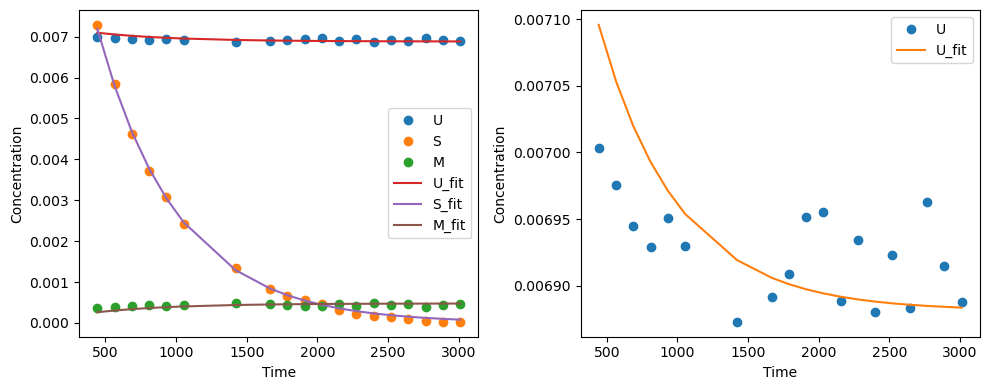

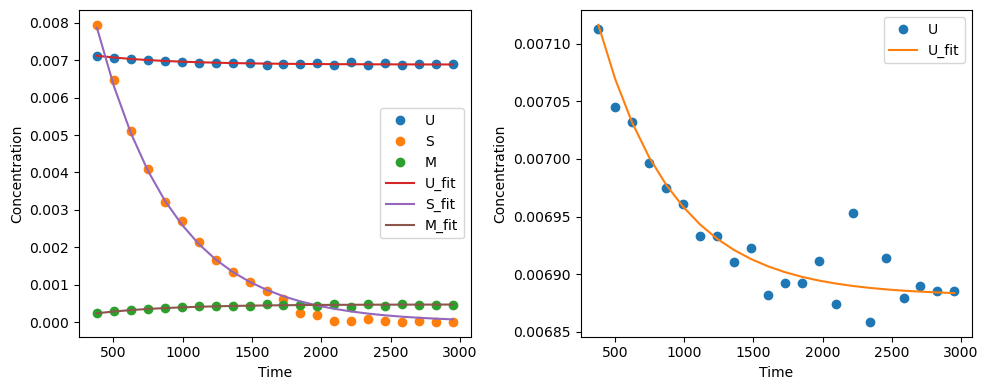

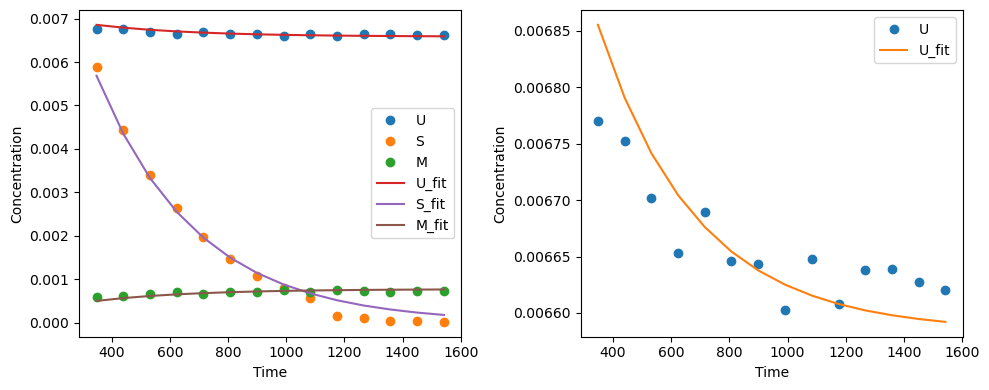

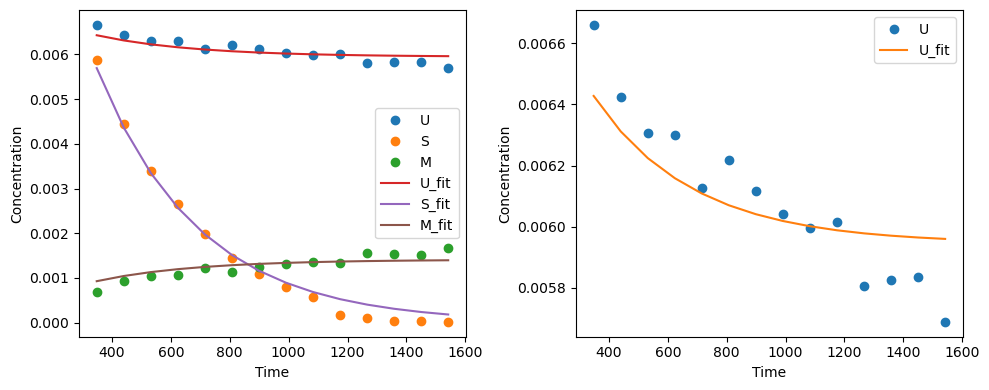

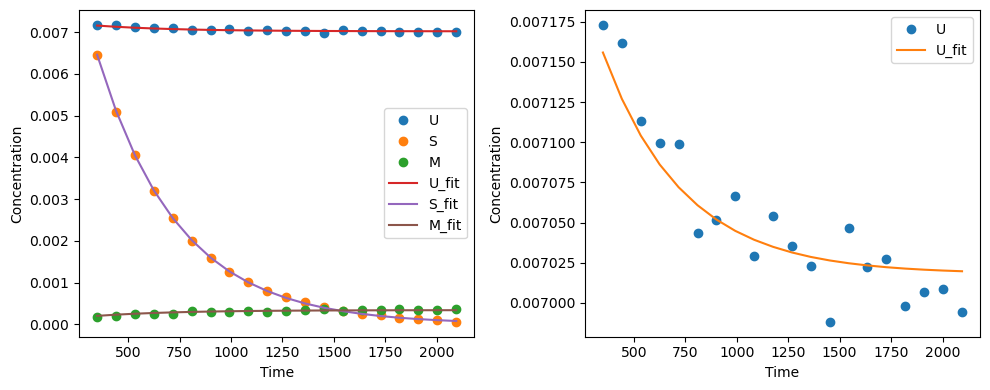

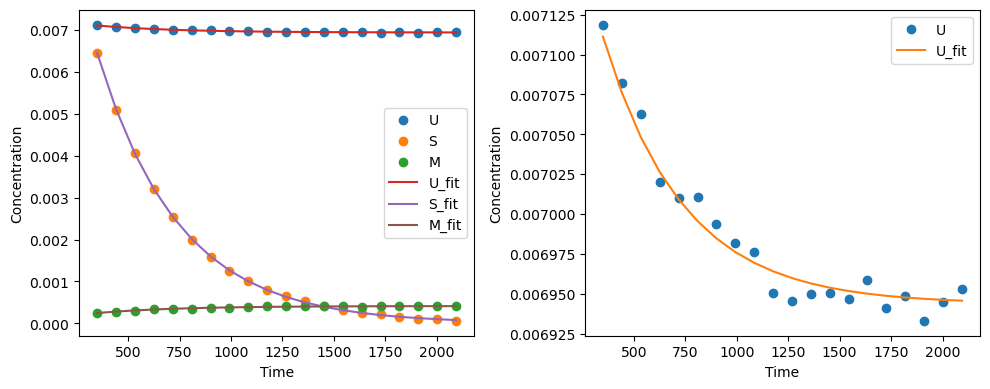

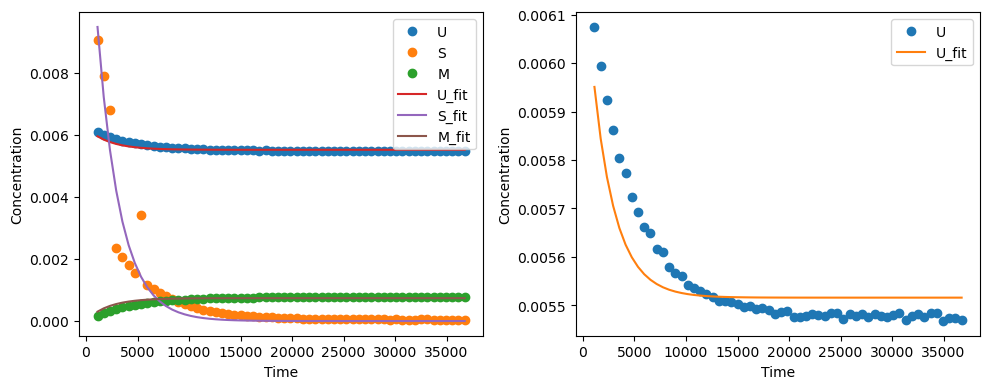

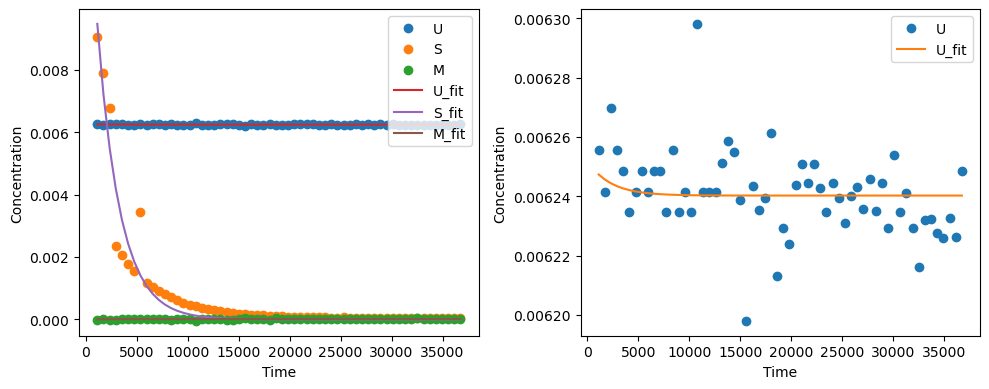

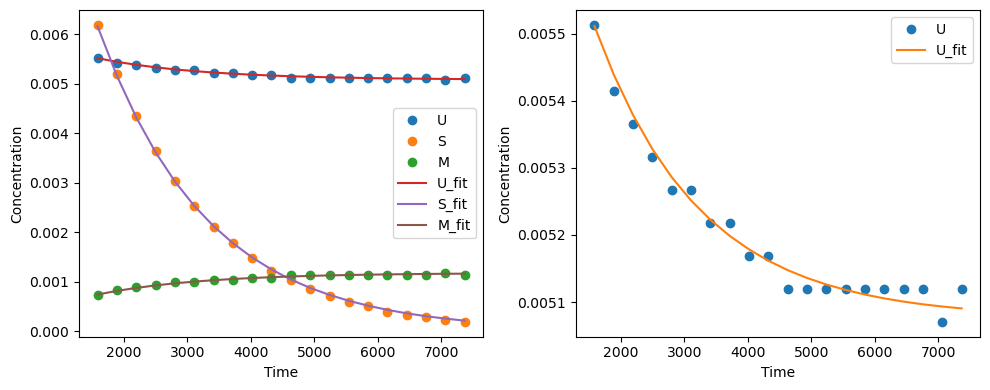

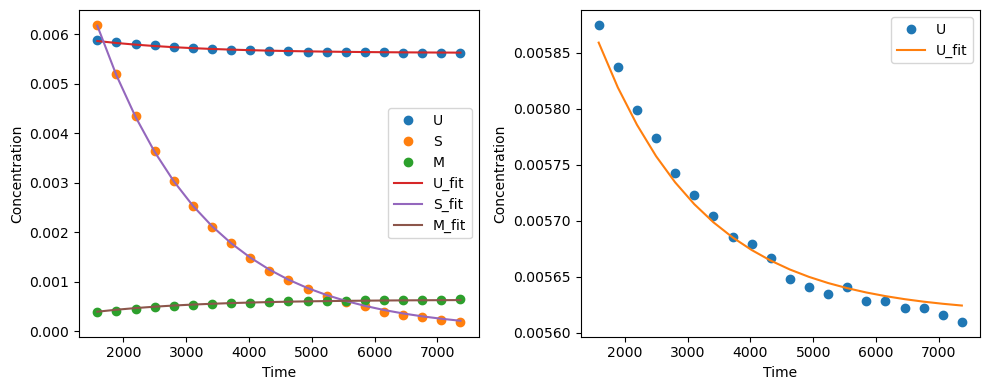

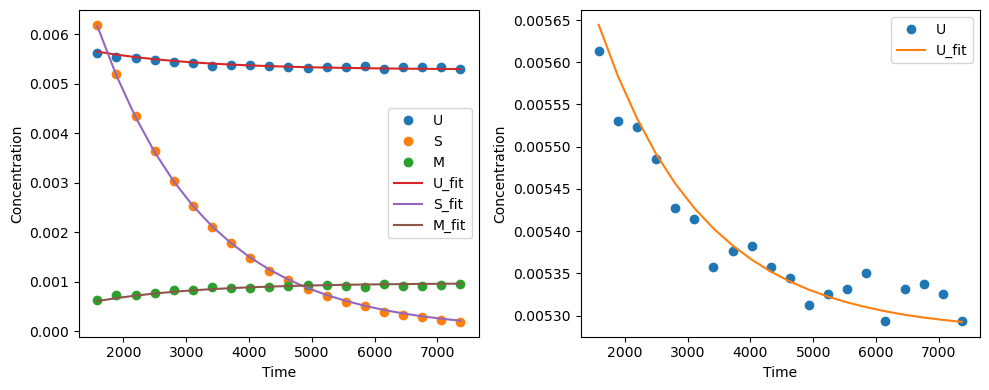

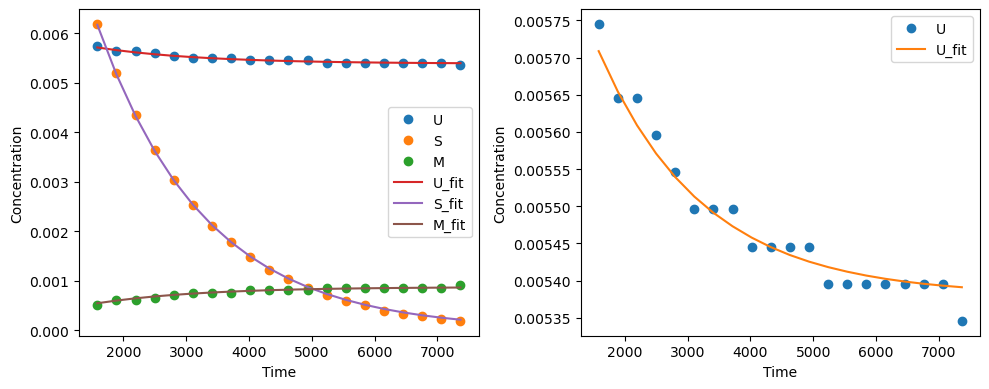

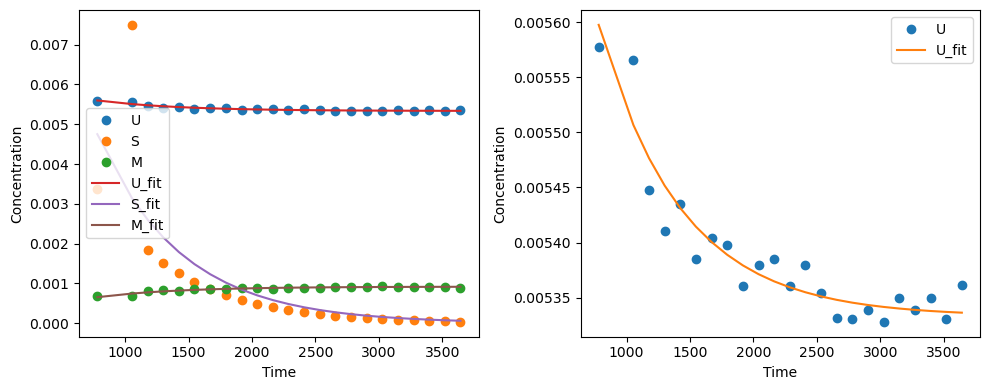

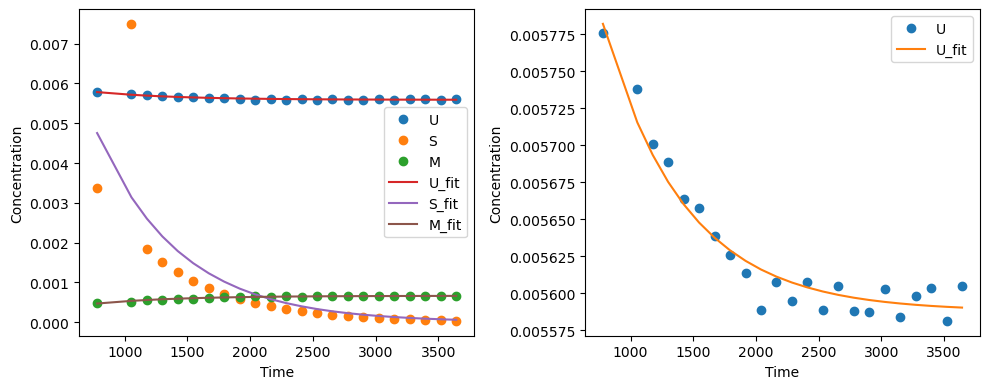

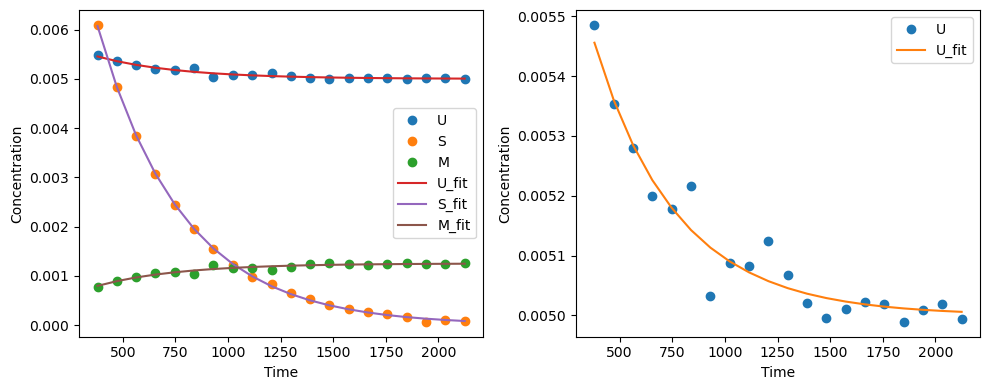

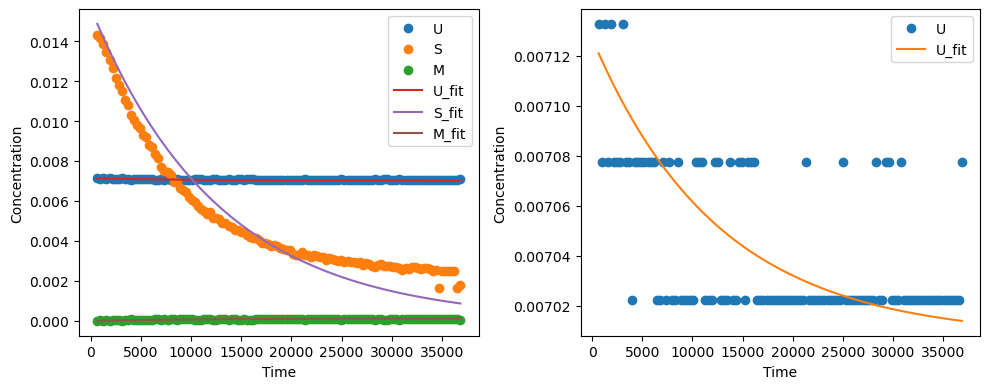

In [134]:
ntps = ['ATP', 'CTP', 'GTP', 'UTP']
temps = {'ATP': [20, 37, 42, 48],
         'CTP': [25, 37, 42, 48],
         'GTP': [25, 33, 42, 48],
         'UTP': [20]}

all_data_storage = []
for ntp in ntps:
    for temp in temps[ntp]:
        all_available_peaks = glob.glob(f'./{ntp}_peak_percentages/{temp}_*.csv')
        
        # Exclude peakDMS
        all_available_peaks = [peak for peak in all_available_peaks if 'peakDMS' not in peak]
        
        for peak in all_available_peaks:
            rep = peak.split('/')[-1].split('_')[1]
            peak = '_'.join(peak.split('/')[-1].split('_')[2:]).split('.')[0]

            dms_perc = pd.read_csv(f'./{ntp}_peak_percentages/{temp}_{rep}_peakDMS.csv')
            peak_perc = pd.read_csv(f'./{ntp}_peak_percentages/{temp}_{rep}_{peak}.csv')

            # plot output
            plot_out = f'./{ntp}_peak_percentages/{temp}_{rep}_{peak}_fit.png'
            params, rsq, chisq = fit_ODE(dms_perc, peak_perc, temp, ntp_conc_dict[ntp], plot_out)

            # unpack parameters to values and errors
            k1 = params['k1'].value
            k1_err = params['k1'].stderr
            k2 = params['k2'].value
            k2_err = params['k2'].stderr

            # save data
            to_store = [ntp, temp, rep, peak, k1, k1_err, k2, k2_err, rsq, chisq]
            print(ntp, temp, rep, peak)
            all_data_storage.append(to_store)

all_data_df = pd.DataFrame(all_data_storage, columns=['ntp', 'temp', 'rep', 'peak', 'k1', 'k1_err', 'k2', 'k2_err', 'rsq', 'chisq'])
all_data_df.to_csv('all_data_initial_fits.csv', index=False)

In [128]:
all_data_df['lnkadd'] = np.log(all_data_df['k1'])
all_data_df['1/T'] = 1 / (all_data_df['temp'] + 273.15)

In [129]:
all_data_df.to_csv('all_data_fitparams.csv', index=False)